# Multi Layer Perceptron - PyTorch
* load mnist data set
* define network
* set loss and optimiser
* train and validate

In [1]:
import torch
import numpy as np
from torchvision import datasets # to load mnist dataset
import torchvision.transforms as transforms # dataset transformations such as totensor

num_workers = 0
batch_size = 64
# data transformations. In this instance, test and train will have the same transformation which is not the case most often
transform = transforms.ToTensor()
# train and test sets
train_set = datasets.MNIST(root='../data',train=True,download=True, transform=transform)
test_set = datasets.MNIST(root='../data',train=False,download=False, transform=transform)
# load generators
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

#### Plot Samples

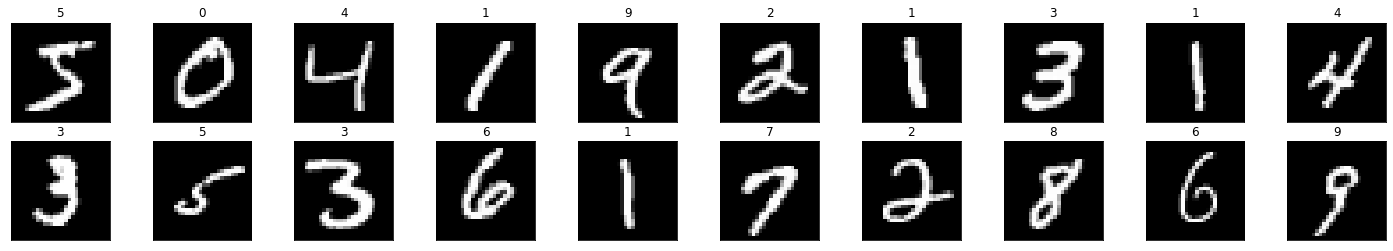

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
dataiter = iter(train_loader)
images, labels = dataiter.next() # get the batch
images = images.numpy() # convert to numpy

fig = plt.figure(figsize = (25,4))
for i in np.arange(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]),cmap='gray')
    ax.set_title(labels[i].item())


#### plot single image in detail

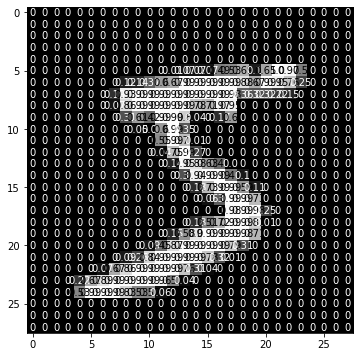

In [3]:
image = np.squeeze(images[0])
figure = plt.figure(figsize = (6,6))
ax = figure.add_subplot(111)
ax.imshow(image,cmap='gray')
width, height = image.shape
tresh = image.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(image[x][y],2) if image[x][y]!=0 else 0
        ax.annotate(str(val),xy=(y,x),horizontalalignment='center',verticalalignment='center',
                   color='white' if image[x][y]<tresh else 'black')

In [4]:
image.shape,images.shape

((28, 28), (64, 1, 28, 28))

In [5]:
images.shape[0]

64

In [6]:
images_t =torch.from_numpy(images)

In [8]:
images_t.view(-1,28*28).shape

torch.Size([64, 784])

## Network Definition

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    
    def __init__(self,batch_size,flat_image_size):
        super(Network,self).__init__()
        self.batch_size = batch_size
        self.flat_image_size = flat_image_size
        #input layer
        self.fc1 = nn.Linear(28*28,128)
        # hidden layers
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.classifier = nn.Linear(32,10)
        # dropout
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        #reshape the image
        x = x.view(-1,self.flat_image_size)
        # network
        x = F.relu(self.fc1(x))
        #second layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        #third layer
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        # output layer
        x = F.log_softmax(self.classifier(x), dim=1)
        return x

In [10]:
model = Network(64, 28*28)

In [11]:
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (classifier): Linear(in_features=32, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


#### Loss and optimiser

In [12]:
from torch import optim
criterion = nn.NLLLoss() # Loss function Negative log likelyhood loss
optimizer = optim.Adam(model.parameters(), lr=0.01) #  learning rate 0.003

In [13]:
def accuracy(y_hat_tensor,label_tensor):
    '''
    args:
        y_hat_tensor tensor: direct output of the model. 
        label_tensor tensor: actual labels of the given items
    returns:
        accuracy float
        accurate float: number of accurately labeled items
        total_samples float : number of samples investigated
    '''
    y_hat_tensor = torch.exp(y_hat_tensor)
    values, pred_labels = y_hat_tensor.max(1) # works like numpy argmax plus returns the values of the cells.
    accurate = sum(1 for a, b in zip(pred_labels.numpy(), label_tensor.numpy()) if a == b)
    total_samples = len(label_tensor)
    accuracy = accurate/total_samples
    return accuracy,accurate,total_samples

In [16]:
epochs = 10
epoch = 0
train_losses = []
test_losses = []
for e in range(epochs):
    running_loss = 0
    total_accurate = 0
    total_samples = 0
    for images, labels in train_loader:
        # Training pass
        #print(images.shape)
        output = model(images) # directly passes the images into forward method
        loss = criterion(output, labels)
        optimizer.zero_grad() # clear gradients
        loss.backward() # compute gradients
        optimizer.step() # update weights
        
        batch_train_accuracy,accurate,total_sample = accuracy(output,labels)
        running_loss += loss.item()
        total_accurate += accurate
        total_samples += total_sample
        #print(total_accurate)
    else:
        with torch.no_grad():
            model.eval()
            test_loss = 0
            total_samples_test = 0
            total_accurate_test = 0
            for images, labels in test_loader:
                output = model(images)
                test_loss += criterion(output, labels)
                batch_test_accuracy,accurate_test,total_sample_test = accuracy(output,labels)
                total_accurate_test += accurate_test
                total_samples_test += total_sample_test
        model.train()
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        print('''---------- epoch : {} -----------'''.format(epoch+1))
        print(''' Training Accuracy = {}  - Training Loss = {}'''.format(total_accurate/total_samples,running_loss/len(train_loader)))
        print(''' Test Accuracy = {}  - Test Loss = {}'''.format(total_accurate_test/total_samples_test,test_loss/len(test_loader)))
        epoch += 1

---------- epoch : 1 -----------
 Training Accuracy = 0.94985  - Training Loss = 0.20333236985123043
 Test Accuracy = 0.9567  - Test Loss = 0.17856796085834503
---------- epoch : 2 -----------
 Training Accuracy = 0.9529  - Training Loss = 0.18658262273530785
 Test Accuracy = 0.9566  - Test Loss = 0.21109309792518616
---------- epoch : 3 -----------
 Training Accuracy = 0.9522333333333334  - Training Loss = 0.18947593261438633
 Test Accuracy = 0.9601  - Test Loss = 0.1856575310230255
---------- epoch : 4 -----------
 Training Accuracy = 0.9566666666666667  - Training Loss = 0.17771522722456223
 Test Accuracy = 0.9623  - Test Loss = 0.17757759988307953
---------- epoch : 5 -----------
 Training Accuracy = 0.9605833333333333  - Training Loss = 0.16015663308186778
 Test Accuracy = 0.9634  - Test Loss = 0.17804965376853943
---------- epoch : 6 -----------
 Training Accuracy = 0.9607  - Training Loss = 0.16137996881524524
 Test Accuracy = 0.9587  - Test Loss = 0.2207762897014618
---------- 

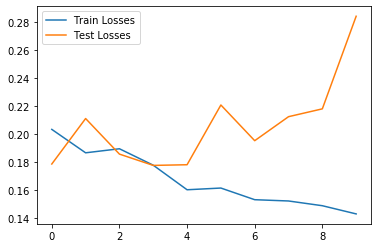

In [17]:
plt.plot(train_losses,label='Train Losses')
plt.plot(test_losses,label='Test Losses')
plt.legend()

#### Display Results

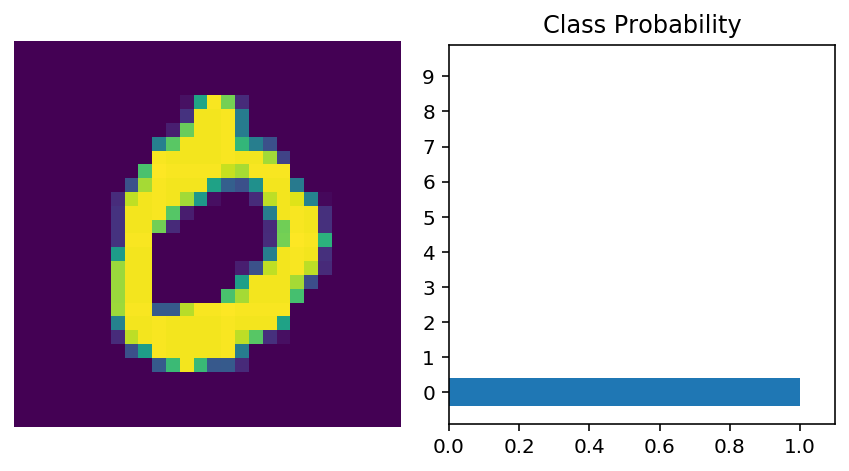

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper1

# Test out your network!

dataiter = iter(test_loader)
images, labels = dataiter.next()
img = images[3]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)
#Calculate the class probabilities (softmax) for img
with torch.no_grad():
    logps = model(img)
ps = torch.exp(logps)
# Plot the image and probabilities
helper1.view_classify(img.resize_(1, 28, 28), ps, version='MNIST')